# Data Cleaning Pipeline

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from scipy.stats import f_oneway
from sklearn.base import BaseEstimator, TransformerMixin


class MissingValuesCategorical(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        object_columns = X.select_dtypes(include=['object'])
        columns_to_drop = ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'Street', 'Utilities', 'LandSlope']
        object_columns = object_columns.drop(columns_to_drop, axis=1)

        columns_to_fill = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                           'Electrical', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
        object_columns[columns_to_fill] = object_columns[columns_to_fill].fillna('NA')
        X = object_columns
        return X

class CleanNumerical(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.columns = None

    def fit(self, X, y=None):
        self.columns = X.select_dtypes(include=['int', 'float']).columns
        return self
    
    def transform(self, X):
        def fix_outliers(df, method, threshold=1.5):
            df_fixed = df.copy()

            for column in df_fixed.select_dtypes(include='number').columns:
                if method == 'IQR':
                    Q1 = df_fixed[column].quantile(0.25)
                    Q3 = df_fixed[column].quantile(0.75)
                    IQR = Q3 - Q1
                    lower_bound = Q1 - threshold * IQR
                    upper_bound = Q3 + threshold * IQR
                    outliers = df_fixed[(df_fixed[column] < lower_bound) | (df_fixed[column] > upper_bound)][column]
                    if not outliers.empty:
                        df_fixed.loc[outliers.index, column] = df_fixed[column].clip(lower=lower_bound, upper=upper_bound)
                elif method == 'Z-score':
                    z_scores = (df_fixed[column] - df_fixed[column].mean()) / df_fixed[column].std()
                    outliers = df_fixed[abs(z_scores) > threshold][column]
                    if not outliers.empty:
                        median_value = df_fixed[column].median()
                        df_fixed.loc[outliers.index, column] = median_value

            return df_fixed
    
        X['GarageYrBlt'].fillna(X['YearBuilt'], inplace=True)
        X['YearBuilt'].fillna(X['GarageYrBlt'], inplace=True)
        X['GarageYrBlt'] = X['GarageYrBlt'].astype(int)
        num_columns = X.select_dtypes(include=['int', 'float'])
        num_columns.drop(['LotFrontage', 'BsmtFinSF1', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'HalfBath',
            'LotArea', 'BsmtFullBath', 'BsmtUnfSF', 'BedroomAbvGr', 'ScreenPorch',
            'PoolArea', 'MoSold', '3SsnPorch', 'BsmtFinSF2', 'BsmtHalfBath',
            'MiscVal', 'LowQualFinSF', 'OverallCond'], axis=1, inplace=True)
        
        # Get columns with missing values
        missing_numeric_cols = num_columns.columns[num_columns.isnull().any()].tolist()
        
        # Impute missing values with mean
        imputer = SimpleImputer(strategy='mean')
        num_columns[missing_numeric_cols] = imputer.fit_transform(num_columns[missing_numeric_cols])
        
        # Fix Outlier
        Fix_Outlier_Num_Data = fix_outliers(num_columns, 'IQR')
        Fix_Outlier_Num_Data.drop(['EnclosedPorch', 'KitchenAbvGr'], inplace = True, axis = 1)
        
        return Fix_Outlier_Num_Data
    
# Define the pipeline
categorical_pipeline = Pipeline([
    ('missing_values', MissingValuesCategorical())
])

numerical_pipeline = Pipeline([
    ('clean_numerical', CleanNumerical())
])

# Apply datacleaning pipelines
db = pd.read_csv("train.csv")
Cleaned_Num_Data = numerical_pipeline.fit_transform(db)
Cleaned_Cat_Data = categorical_pipeline.fit_transform(db)
Cleaned_DB = Cleaned_Cat_Data.join(Cleaned_Num_Data, how='left')
for cols in Cleaned_DB.columns:
    if Cleaned_DB[cols].isnull().sum():
        print(cols, Cleaned_DB[cols].isnull().sum())

In [2]:
Cleaned_Num_Data.head()

,Id,MSSubClass,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,YrSold,SalePrice
0,1,60,7,2003,2003,196.0,856,856.0,1710.0,2,8,0.0,2003,2.0,548.0,2008,208500.0
1,2,20,6,1976,1976,0.0,1262,1262.0,1262.0,2,6,1.0,1976,2.0,460.0,2007,181500.0
2,3,60,7,2001,2002,162.0,920,920.0,1786.0,2,6,1.0,2001,2.0,608.0,2008,223500.0
3,4,70,7,1915,1970,0.0,756,961.0,1717.0,1,7,1.0,1998,3.0,642.0,2006,140000.0
4,5,60,8,2000,2000,350.0,1145,1145.0,2198.0,2,9,1.0,2000,3.0,836.0,2008,250000.0


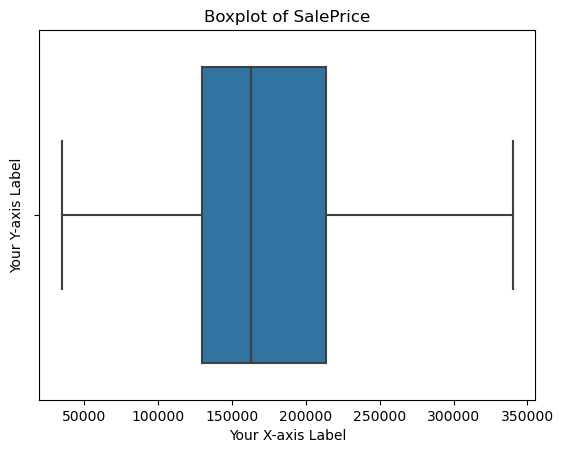

In [3]:
column_name = 'SalePrice'
sns.boxplot(x=Cleaned_Num_Data[column_name])
plt.xlabel('Your X-axis Label')
plt.ylabel('Your Y-axis Label')
plt.title('Boxplot of ' + column_name)
plt.show()

# Preprocessing Pipeline

1) Numerical Features

In [4]:
# Load the dataset
data = Cleaned_DB

# These are the Year columns that should not be included in Standard Scaling in preprocessing
numerical_cols = Cleaned_Num_Data.drop(columns = ['Id', 'SalePrice', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']).columns
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        # ('cat', categorical_transformer, categorical_cols)
        ('num', numerical_transformer, numerical_cols)
    ])

x_preprocessed = preprocessor.fit_transform(data)
x_preprocessed_df = pd.DataFrame(x_preprocessed, columns=numerical_cols)
data[numerical_cols] = x_preprocessed_df[numerical_cols] 

pd.set_option('display.max_columns', None)
data.head()

,MSZoning,LotShape,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,Id,MSSubClass,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,YrSold,SalePrice
0,RL,Reg,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,1,0.131067,0.652644,2003,2003,0.792353,-0.488321,-0.830489,0.428636,0.789741,0.981148,-0.957043,2003,0.315946,0.373509,2008,208500.0
1,RL,Reg,Lvl,FR2,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,2,-0.935733,-0.073068,1976,1976,-0.672399,0.532289,0.289638,-0.502349,0.789741,-0.316385,0.608540,1976,0.315946,-0.051541,2007,181500.0
2,RL,IR1,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,3,0.131067,0.652644,2001,2002,0.538263,-0.327437,-0.653917,0.586571,0.789741,-0.316385,0.608540,2001,0.315946,0.663315,2008,223500.0
3,RL,IR1,Lvl,Corner,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml,4,0.397766,0.652644,1915,1970,-0.672399,-0.739702,-0.540801,0.443182,-1.026041,0.332382,0.608540,1998,1.662750,0.827539,2006,140000.0
4,RL,IR1,Lvl,FR2,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,5,0.131067,1.378355,2000,2000,1.943229,0.238172,-0.033157,1.442744,0.789741,1.629914,0.608540,2000,1.662750,1.764579,2008,250000.0


2) Categorical Features

In [5]:
categorical_cols = Cleaned_Cat_Data.columns
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols)
    ])

x_preprocessed = preprocessor.fit_transform(data)
encoded_columns = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)
x_preprocessed_df = pd.DataFrame.sparse.from_spmatrix(x_preprocessed, columns=encoded_columns)
x_preprocessed_df.head()
data = data.drop(categorical_cols , axis=1)
data[encoded_columns] = x_preprocessed_df[encoded_columns] 

# pd.set_option('display.max_columns', None)
data.head()

,Id,MSSubClass,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,YrSold,SalePrice,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NA,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_NA,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_NA,BsmtExposure_No,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NA,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_NA,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_NA,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NA,GarageFinish_Fin,GarageFinish_NA,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_NA,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_NA,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_N

# Model Training Via Gradient Boosting Regressor

In [6]:
# Separate features and target variable
X = data.drop(columns=['SalePrice'])
y = data['SalePrice']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = Pipeline(steps=[
    ('regressor', GradientBoostingRegressor(random_state=42))
])
# Fit the model
model.fit(X_train, y_train)

C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Pipeline(steps=[('regressor', GradientBoostingRegressor(random_state=42))])

In [7]:
y_pred = model.predict(X_test)
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

# Print the metrics of the model
print(f"Training R^2 score: {train_score}")
print(f"Test R^2 score: {test_score}")
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)

Training R^2 score: 0.9562308661214591
Test R^2 score: 0.9097348039432658
Mean Absolute Error (MAE): 15060.715528109284
Mean Squared Error (MSE): 441329107.0169316
Root Mean Squared Error (RMSE): 21007.834419971317
R-squared (R2): 0.9097348039432658


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


# Testing Other ML Models 

In [11]:

X = data.drop(columns=['SalePrice'])
y = data['SalePrice']

models = [
    ('GradientBoosting', GradientBoostingRegressor()),
    ('RandomForest', RandomForestRegressor()),
    ('LinearRegression', LinearRegression()),
    ('KNeighbors', KNeighborsRegressor()),
    ('DecisionTree', DecisionTreeRegressor())
]

# Create a list to store the results
results_list = []

# Iterate over models
for name, model in models:
    # Build pipeline with preprocessing and current model
    model_pipeline = Pipeline(steps=[
        ('regressor', model)
    ])
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit the model
    model_pipeline.fit(X_train, y_train)
    
    # Predictions
    y_pred = model_pipeline.predict(X_test)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    train_score = model_pipeline.score(X_train, y_train)
    test_score = model_pipeline.score(X_test, y_test)
    
    # Append results to the list
    results_list.append({
        'Model': name,
        'Training R^2': train_score,
        'Test R^2': test_score,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    })

# Create a DataFrame from the list of results
results_df = pd.DataFrame(results_list)

# Display results
print(results_df)

C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-pa

              Model  Training R^2  Test R^2           MAE           MSE  \
0  GradientBoosting      0.952637  0.908142  15356.900548  4.491183e+08   
1      RandomForest      0.982028  0.903332  15479.253990  4.726334e+08   
2  LinearRegression      0.935188  0.890910  16570.511054  5.333677e+08   
3        KNeighbors      0.596814  0.342904  43830.039384  3.212709e+09   
4      DecisionTree      1.000000  0.806950  21888.371575  9.438697e+08   

           RMSE        R2  
0  21192.410396  0.908142  
1  21740.133979  0.903332  
2  23094.755140  0.890910  
3  56680.760324  0.342904  
4  30722.461917  0.806950  


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
